In [1]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 22 kB/s /s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [4]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_frac_pca.h5')
X_pca = store['X_frac_pca']

store = pd.HDFStore('X_frac_mob.h5')
X_mob = store['X_frac_mob']

store = pd.HDFStore('X_frac_month.h5')
X_month = store['X_frac_month']

store = pd.HDFStore('X_frac_year.h5')
X_year = store['X_frac_year']

store = pd.HDFStore('y_frac_default.h5')
y_default = store['y_frac_default']

store = pd.HDFStore('y_frac_prepay.h5')
y_prepay = store['y_frac_prepay']

X_pca = X_pca.join(X_mob)
X_pca = X_pca.join(X_month)
X_pca = X_pca.join(X_year)

In [5]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,mob,Orig_month,Orig_year
0,-0.962154,0.779693,-0.531650,1.163163,-0.682093,-0.045649,-0.699041,0.055255,0.162676,-0.467432,0.866656,8,9,2016
1,-0.028577,0.512777,-3.078022,-0.486987,0.035361,0.674300,0.220458,-0.045611,0.031261,0.353778,0.294199,18,11,2017
2,2.060993,-1.548725,0.307346,-1.974885,1.082134,1.242044,-1.556453,-0.163582,0.271928,-0.377169,-0.707195,13,10,2017
3,-0.178743,-0.113873,-1.083110,1.937141,0.374389,0.737874,-0.047516,-0.125002,0.038776,0.684467,-1.059683,2,1,2017
4,2.233706,1.557031,3.643915,0.838310,0.445104,-0.501903,0.008767,-0.086495,-0.086662,-0.241188,0.137264,19,12,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10381408,-0.848187,-3.450802,1.557602,1.248862,-0.743700,-0.334758,0.118758,0.001479,0.039592,0.556514,-1.046651,15,1,2018
10381409,-1.839038,-0.971882,-1.059122,-0.757796,-0.481800,0.077750,-0.519510,0.085826,0.124009,-0.391467,1.122011,10,9,2017
10381410,-0.163434,-1.429780,1.828670,0.269189,-0.241291,-0.310633,-0.783661,0.060361,0.115486,-0.660535,0.897127,27,9,2017
10381411,-3.796968,-0.306893,2.271271,-1.221589,0.313238,-0.874047,-0.323709,0.051678,-0.026745,-0.586963,0.524738,24,4,2016


In [6]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_default, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.773


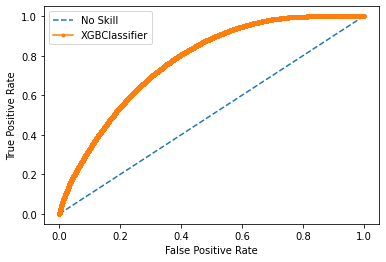

943.6443338394165 s


In [7]:
time_start = time.time()
model = xgb.XGBClassifier(max_depth= 3, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

# save the model to disk
filename = 'xgb_model_default.sav'
#filename = 'xgb_model_date_default.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))


# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")

In [8]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.635


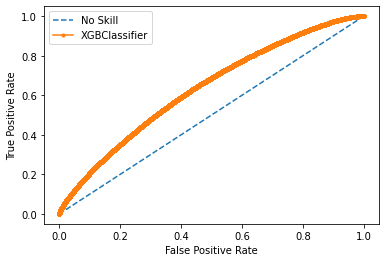

947.0856041908264 s


In [9]:
time_start = time.time()
model = xgb.XGBClassifier(max_depth= 3, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

filename = 'xgb_model_prepay.sav'
#filename = 'xgb_model_date_prepay.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")